Here, we will use a dataset, called CIFAR-10. It has been a computer vision classic for a decade.

7.1.1 Downloading CIFAR-10

In [1]:
from torchvision import datasets

data_path = '../CIFAR-10/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


The second argument specifies whether we're interested in the training set or validation set; and the third says whether we allow Pytorch to download the data if it is not found in the location specified in the first argument.

The dataset is returned as a subclass of torch.utils.data.Dataset

In [2]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

7.1.2 The dataset class: 

It's an object that is required to implement two methods:$\_\_len\_\_$ and $\_\_getitem\_\_$. The former should return the number of items in the dataset; the latter should return the item, consisting of a sample and its corresponding label.

In [3]:
len(cifar10)

50000

We can use the standard subscript for indexing tuples and lists to access individuals items.

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F70A09BFCF8>,
 1,
 'automobile')

So the sample in the data.CIFAR10 dataset is an instane of an RGB PIL(Python Image Library) image. We can plot it

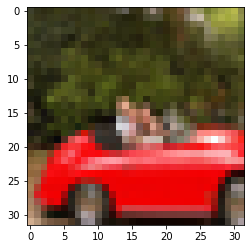

In [5]:
from matplotlib import pyplot as plt

plt.imshow(img)
plt.show()

7.1.3 Dataset transforms:

We'll likely need a way to convert the PIL image to a PyTorch tensors. The torchvision.transforms defines a set of composable, function-like objects that can be passed as an argument to a torchvision dataset such as datasets.CIFAR10(), and that perform transformation on the data after it's loaded but before it is returned by \_\_getitem\_\_. Let's see the list of available objects as follows:

In [6]:
from torchvision import transforms
dir(transforms)[:5]

['AutoAugment', 'AutoAugmentPolicy', 'CenterCrop', 'ColorJitter', 'Compose']

Among these transforms, we can spot $ToTensor$, which turns NumPy arrays and PIL images to tensors. It also takes care to lay out the dimensions of the output tensors as C\*H\*W (channel, height, weight)

In [7]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

A three channel(RGB) 32 $\times$ 32 images. Note that nothing has happened to label; it is still an integer.

As we anticipated, we can pass the transform directly as an argument to dataset.CIFAR10

In [8]:
tensor_cifar10 = datasets.CIFAR10(data_path,
                                  train=True,
                                  download=False,
                                  transform=transforms.ToTensor())

At this point, accessing an element of the dataset will return a tensor, rather than a PIL image:

In [9]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [10]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

Whereas the values in the orginal PIL image ranged from 0 to 255, the ToTensor turns the data into a 32-bit floating-point per channel, scaling the values down from 0.0 to 1.0

In [11]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

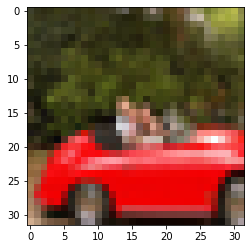

In [12]:
# changes the order of axes from C*H*W to H*W*C to match what matplotlib expects
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

7.1.4 Normalizing data

We can chain them using transforms.Compose, and they can handle normalization and data augmentation transparently, directly in the data loader. For instance, it's good practice to normalize the dataset so that each channel has zero mean and unitary sd.

The values of mean and stdev must be computed offline. Let's stack all the tensors returned by the dataset along an extra dimension:

In [13]:
import torch

imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

Now we can easily compute the mean per channel:

In [14]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

Recall that view(3, -1) keeps the three channel and merges all the remaining dimension into one, figuring out the appropriate size. Here our 3\*32\*32 image is transformed into a 3\*1024 vector, and then the mean is taken over the 1024 elements of each channel.

Computing the stdev is similar:

In [15]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

With these number in our hands, we can initialize the $Normalize$ transform.

In [16]:
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

and concatenate it after the $ToTensor$ transform:

In [17]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                      transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                                                        (0.2470, 0.2435, 0.2616))]))

In [18]:
cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                           transform=transforms.Compose([transforms.ToTensor(),
                                                         transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                                              (0.2470, 0.2435, 0.2616))]))

cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                               transform=transforms.Compose([transforms.ToTensor(),
                                                             transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                                                  (0.2470, 0.2435, 0.2616))]))

## 7.2 Distinguishing birds from airplanes
7.2.1 Building the dataset

We could create a $Dataset$ subclass that only includes birds and airplanes. We can take a shortcut and just filter the data in cifar10 and remap the labels so they are contiguous.

In [19]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]

cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

7.2.2 A fully connected model

In this demo, how many features per sample? Well, 32\*32\*32\*3 = 3072 inputs features per sample. We will use linear model again :)?

Our new model would be an nn.Linear with 3072 input features and some numbers of hidden numbers.

In [20]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(nn.Linear(3072, 512,),
                      nn.Tanh(),
                      nn.Linear(512, n_out,))

7.2.3 Output of a classifier. In the ideal case, the network would output torch.tensor([1.0, 0.0]) for an airplane and torch.tensor([0.0, 1.0]) for a bird.

7.2.4 Representing the output as probabilities. Softmax is a function that takes a vector of values and produces another vector of the same dimension, where the values satisfy the constraints we just listed to represent probabilities.

Let's test it on an input vector:

In [21]:
def softmax(x):
    return torch.exp(x)/torch.exp(x).sum()
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [22]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

We can now add a softmax at the end of our model, and our network will be equiped to produce probabilities.

In [23]:
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 2),
                      nn.Softmax(dim=1))

In order to call the model, we need to make the input have the right dimensions. We recall that our model expects 3072 input features, and that nn works with data organized into batch along the zeroth dimension. So we need to turn 3\*32\*32 image into a 1D tensor and then add an extra dimension in the zeroth position:

In [24]:
img, _ = cifar2[0]

img_batch = img.view(-1).unsqueeze(0)

In [25]:
out = model(img_batch)
out

tensor([[0.4902, 0.5098]], grad_fn=<SoftmaxBackward>)

Time to get training.

7.2.5 A loss for classifying: We want a loss function that is very high when the likelihood is low. There is a loss function that behaves that way, and it's called $negative\_log\_likelihood$ (NLL). Summing up, our loss for classification can be computed as follows. For each sample in the bacth:
1. Run the forward pass, and obtain the output values from the last layer
2. Compute the softmax, and obtain probabilities
3. Take the predicted probability corresponding to the correct class. Note that we know what the correct class is because it's a superviesd problem.
4. Compute its logarithm, slap a minus sign in front of it, and add it to the loss

In [26]:
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 2),
                      nn.LogSoftmax(dim=1))

Then we instantiate our NLL loss:

In [27]:
loss = nn.NLLLoss()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1

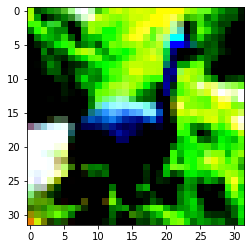

In [28]:
img, label = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
label

In [29]:
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.7939, grad_fn=<NllLossBackward>)

7.2.6 Training the classifier

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 2),
                      nn.LogSoftmax(dim=1))

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

n_epochs = 100
for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

In our training code, we choose minibatches of size 1 by picking one item at a time from the dataset. The torch.utils.data module has a class that helps with shuffling and organizing the data in minibatches: Dataloader.

The job of a data loader is to sample minibatches from a dataset, giving us the flexibility to choose from different sampling strategies. A very common strategy is uniform sampling after shuffling the data at each epoch.

In [31]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [32]:
torch.cuda.is_available()

True

In [ ]:
import torch
import torch.nn as nn
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 2),
                      nn.LogSoftmax(dim=1))

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

we can compute the accuracy of our model on the validation set in terms of the number of correct classifications over the total:

In [34]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy: %f", correct / total)

Accuracy: %f 0.812


It's quite common to drop the last nn.LogSoftmax layer from the network and use nn.CrossEntropyLoss as a loss. Let us try that:

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.361836
Epoch: 1, Loss: 0.228973
Epoch: 2, Loss: 0.298336
Epoch: 3, Loss: 0.499869
Epoch: 4, Loss: 0.357887
Epoch: 5, Loss: 0.344600
Epoch: 6, Loss: 0.178505
Epoch: 7, Loss: 0.379637
Epoch: 8, Loss: 0.370935
Epoch: 9, Loss: 0.878428
Epoch: 10, Loss: 0.950302
Epoch: 11, Loss: 0.270932
Epoch: 12, Loss: 0.282296
Epoch: 13, Loss: 0.576294
Epoch: 14, Loss: 0.950157
Epoch: 15, Loss: 0.519083
Epoch: 16, Loss: 0.339401
Epoch: 17, Loss: 0.277401
Epoch: 18, Loss: 0.448433
Epoch: 19, Loss: 0.221876
Epoch: 20, Loss: 0.307782
Epoch: 21, Loss: 0.194784
Epoch: 22, Loss: 0.235053
Epoch: 23, Loss: 0.340276
Epoch: 24, Loss: 0.263133
Epoch: 25, Loss: 0.492113
Epoch: 26, Loss: 0.148804
Epoch: 27, Loss: 0.394775
Epoch: 28, Loss: 0.168948
Epoch: 29, Loss: 0.079750
Epoch: 30, Loss: 0.559918
Epoch: 31, Loss: 0.189379
Epoch: 32, Loss: 0.422231
Epoch: 33, Loss: 0.341690
Epoch: 34, Loss: 0.101193
Epoch: 35, Loss: 0.346187
Epoch: 36, Loss: 0.103391
Epoch: 37, Loss: 0.205965
Epoch: 38, Loss: 0.101

In [40]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.808000


Pytorch offers a quick way to determine how many parameters a model has through the $parameters()$ method of $nn.Model$.

In [41]:
numel_list = [p.numel() 
              for p in model.parameters() 
              if p.requires_grad==True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

Let's check the quantity of parameters:

In [42]:
linear = nn.Linear(3072, 1024)
linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

Our neural network won't scale very well with the number of pixels. What if we had a $1024\times 1024$ RGB image? That's 3.1 million inputs values. Even abruptly going to 1024 hidden features, we would have over 3 billion parameters. Using 32-bit floats, we're already at 12GB RAM, and we haven't even hit the second layer, much less computed and stored the gradients.